<a href="https://colab.research.google.com/github/PapaZeusOne/Dead-Cat-Bounce/blob/main/Data_Driven_Business_%7C_Dead_Cat_Bounce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ToDo-Section**


Mitschriften
1.   Learning wenn wir auch einen Abfragebaum schreiben und oder Daten händisch eintragen
2.   Random-Forest-Tree
3.   08.01.2021 Abschlusspräsentation
4.   Ergebnisorientierte Präsentation halten
5.   Interpretation der Ergebnisse 
6.   Quellen darstellen
7.   Rahmen = 15-20 Minuten 

Indikatoren:
*   Moving Average
*   MACD
*   Signalline
*   Bollinger-Bands
*   Arima?


Torben:

*   Decision-Tree
*   MA, Bollinger-Bands erklären

Adrian:


*   Visualisierungen, Arima
*   MACD anschauen und vom Histogram die Bewegungen herausfiltern. Bedingung schreiben, dass wenn MACD und Signalline sich kreuzen, Markt bärisch wird und somit die erste Bedingung für einen DCB zutrifft.  

Joe Biden: 


*   Warum ist ein Prediction Model nicht für den DCB anwendbar?



##**Anforderungen an einen Dead-Cat-Bounce**


Ähnlichkeiten zu einem Double-Dip erkennbar



1.   Kurs befindet sich bereits in einem Abwärtstrend (Bärenmarkt).
2.   Ein Dead Cat Bounce liegt vor, wenn der Kurs um 5 % oder mehr nach unten kippt, weiter sinkt, dann aber eine Rallye erlebt.
3.   Der Kurs erlebt nur eine kurzzeitige Erholung und ist weiter bärisch.



**Darstellung eines Drawdown**

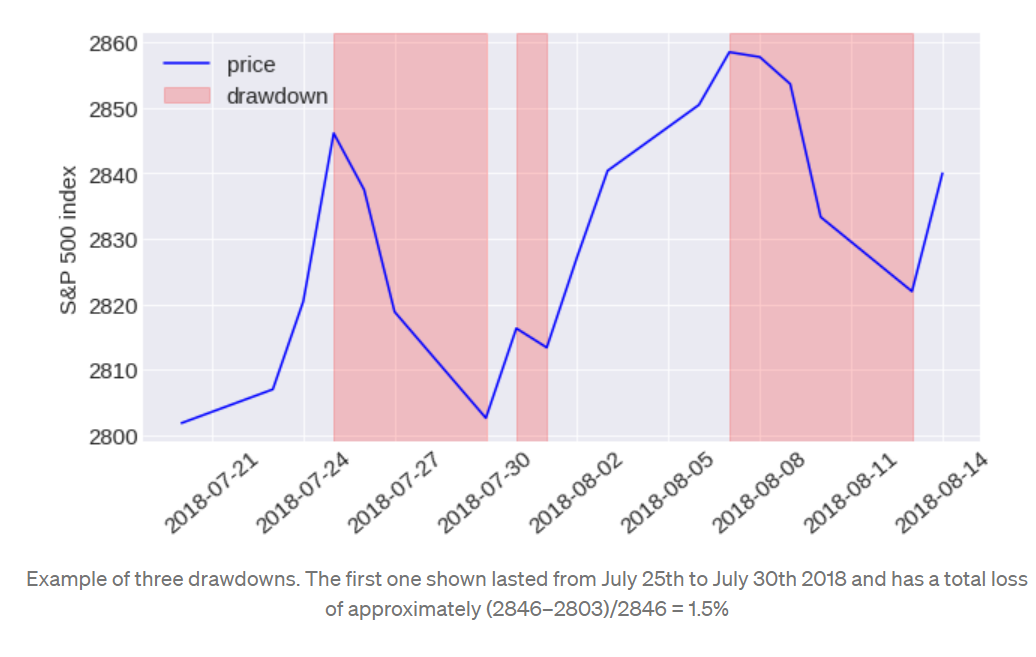

#**Analysis of a Dead Cat Bounce for the stock market with focus on the S&P500**




# **Business Understanding**

**What is our main goal with this project?**


> Offer possibilities for short-term trades.

> Indicate false recovery and alert long-term trades to not invest. 



# **Data Preperation**

Installing all necessary dependencies for the project. Packages for RFT are listed seperately.



In [121]:
#Install the dependencies
import numpy as np 
import pandas as pd
import os, io
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import datetime as dt
import requests
import pandas_datareader.data as web
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt



---


*   Main usage of yahoo finance API.
*   Working with the S&P500 stock.
*   Data is generated automatically.
*   Time period flexible.



---

The S&P500 index consists of the 500 most valuable companies from the USA and combines them in an index. Therefore specific market movements are more average. It helps to train the model faster and better.

In [122]:
stock_id = '^GSPC'

start = dt.datetime(2018,1,1)
end = dt.datetime.now()
end_test = dt.datetime(2020,4,4)

stock = web.DataReader(stock_id, 'yahoo', start, end)
df = stock
df.dropna(inplace=True)

**Data Modelling for:**


*   Moving Averages (EMA)
*   MACD
*   Signalline
*   Histogram
*   Bollinger Bands
*   Decision Tree
*   Random-Forest Tree
*   Dead Cat Bounce



In [123]:
indicator = pd.DataFrame(df, index=df.index)

# 30 day
short_window = 30
# 50 day
long_window = 50
# 20 day
bollinger_avg = 20

# Exponential moving averages using the closing data
indicator['short_avg'] = df['Close'].ewm(span=short_window, adjust=False).mean()
indicator['long_avg'] = df['Close'].ewm(span=long_window, adjust=False).mean()

# Defining bollinger averages for 20 days.
indicator['bollinger_avg'] = df['Close'].ewm(span=bollinger_avg, adjust=False).mean()

# Compute EMA by defining short- and long average. 12 days and 26 days
indicator['ema_short_avg'] = df['Close'].ewm(span=12, adjust=False).mean()
indicator['ema_long_avg'] = df['Close'].ewm(span=26, adjust=False).mean()

# Get MACD by dividing EMA (12 days) - EMA (26 days)
indicator['macd'] = indicator['ema_short_avg'] - indicator['ema_long_avg']

# Another parameter is the signal line with a smoothing of nine days, which is calculated as a moving average of the MACD line.
indicator['signalline'] = indicator['macd'].ewm(span=9, adjust=False).mean()

# Used to project histogram and identify falling or rising movements. Important to correctly analyze a Dead-Cat-Bounce
# Info: *2 is used for better visualization
indicator['histogram_macd_signalline'] = (indicator['macd'] - indicator['signalline'])*2

# Calculate 30 Day Moving Average, Std Deviation, Upper Band and Lower Band
indicator['short_avg_ma'] = df['Close'].rolling(window=bollinger_avg).mean()

# Calculate short average standard deviation for plotting bollinger (avg) bands
indicator['short_avg_std'] = df['Close'].rolling(window=bollinger_avg).std()

# calculate upper and lower band 
indicator['upper_band'] = indicator['short_avg_ma'] + (indicator['short_avg_std'] *2)
indicator['lower_band'] = indicator['short_avg_ma'] - (indicator['short_avg_std'] *2)

# **Telegram Bot Setup**

In [124]:
def send_push(text):
    
    # Change the strings: <TOKEN> and <CHAT_ID>, with your token and chat_id
    bot_token_id = '1619242285:AAH7lgAYnbYyE6-Lpp53h57ChFBy4-bzkUg'
    bot_chat_id = '908941210'
    
    send_text = 'https://api.telegram.org/bot' + bot_token_id + '/sendMessage?chat_id=' + bot_chat_id + '&parse_mode=Markdown&text=' + text
    
    response = requests.get(send_text)

    return response.json()

send_push('This bot is working now!')

{'ok': True,
 'result': {'chat': {'first_name': 'Adrian',
   'id': 908941210,
   'last_name': 'Sarwari',
   'type': 'private'},
  'date': 1612039113,
  'from': {'first_name': 'Dead Cat Bounce',
   'id': 1619242285,
   'is_bot': True,
   'username': 'bounce_dead_bot'},
  'message_id': 184,
  'text': 'This bot is working now!'}}

# **Method Gathering (mainly for plots)**

This section is used to build methods which will support further reading.

In [125]:
# Build methods for plotting more easily graphs
def figure_add_trace(figure, indicator, name, color):
  figure.add_trace(go.Scatter(x=df.index,
                              y=indicator,
                              mode='lines',
                              name=name,
                              line=go.scatter.Line(color=color)))
  
def figure_add_fill_trace(figure, indicator, fill, name, color):
  figure.add_trace(go.Scatter(x=df.index,
                              y=indicator,
                              fill=fill,
                              name=name,
                              mode='lines',
                              fillcolor='rgba(220,220,220,0.5)',
                              line_color=color))

def figure_update_layout(figure, name, xaxis_label, yaxis_label):
  figure.update_layout(
      title=name, 
      xaxis_title=xaxis_label,
      yaxis_title=yaxis_label,
      xaxis_rangeslider_visible=False,
      )

# **Moving Averages & Bollinger Bands**

**What is a Moving Average (MA)?**


> In statistics, a moving average is a calculation used to analyze data points by creating a series of averages of different subsets of the full data set.

> The reason for calculating the moving average of a stock is to help smooth out the price data by creating a constantly updated average price.

> Moving averages are usually calculated to identify the trend direction of a stock or to determine its support and resistance levels. It is a trend-following—or lagging—indicator because it is based on past prices.



---


**What are the so called "Bollinger Bands"?**


> A Bollinger Band is a technical analysis tool defined by a set of trendlines plotted two standard deviations (positively and negatively) away from a simple moving average (SMA) of a security's price, but which can be adjusted to user preferences.

> Many traders believe the closer the prices move to the upper band, the more overbought the market, and the closer the prices move to the lower band, the more oversold the market.

> The Bollinger Bands basically create a dynamic trend, as the moving average moves continuously and follows the movements of the underlying asset. Therefore, in volatile times, the spacing of the Bollinger Bands is relatively wide and in calm market phases, it is much smaller.





In [126]:
# S&P500 Stock
figure_stock = go.Figure(data=[
                               go.Candlestick(
                                   x=df.index,
                                       open=df['Open'],
                                       high=df['High'],
                                       low=df['Low'],
                                       close=df['Close'],
                                       name='S&P 500'),
                               ])

In [127]:
figure_add_fill_trace(figure_stock, indicator['upper_band'], None, 'Lower Band', 'lightgrey')
figure_add_fill_trace(figure_stock, indicator['lower_band'], 'tonexty', 'Upper Band', 'lightgrey')
figure_add_trace(figure_stock, indicator['bollinger_avg'], 'Bollinger Average', 'black')

figure_add_trace(figure_stock, indicator['short_avg'], '30 Days Average', 'yellow')
figure_add_trace(figure_stock, indicator['long_avg'], '50 Days Average', 'purple')
figure_update_layout(figure_stock, 'Stock Movement for S&P500', 'Date', 'Stock Price')

# **MACD & Signalline**

**What is the MACD & the Signalline?**


The MACD turns two trend-following indicator, moving averages, into a momentum oscillator by subtracting the longer moving average from the shorter one. As a result, the MACD offers trend following and momentum for the stock market.
The MACD fluctuates above and below the zero line as the moving averages converge, cross and diverge. MACD is all about the convergence and divergence of the two moving averages.



---
Calculation:
> MACD Line: (12-day EMA - 26-day EMA): Time period is flexible and depends on trading style.

> Signal Line: 9-day EMA of MACD Line

> MACD Histogram: MACD Line - Signal Line


---
Why should we use the MACD for understanding the Dead-Cat-Bounce?
> If Signal-Line is bigger than MACD, the market tends to fall.

> Dead-Cat-Bounce spotable by plotting histogram.

> Crossovers represent a change in market movement. 






In [128]:
# Graph with MACD, Signalline and Histrogram
figure_macd = go.Figure()
figure_add_trace(figure_macd, indicator['macd'], 'MACD', 'blue')
figure_add_trace(figure_macd, indicator['signalline'], 'Signal-Line (SL)', 'red')

figure_macd.add_trace(go.Bar(x=df.index,
                        y=indicator['histogram_macd_signalline'],
                        name='MACD - SL',
                        textposition='auto',
                        marker_color='lightslategray'))

figure_update_layout(figure_macd, 'MACD and Signal-Line for S&P500', 'Date', '')

# **Dead Cat Bounce Calculation**

**What conditions should be considered to analyze a dead-cat-bounce?**


> Price is already in a downward trend (bear market).

> A Dead Cat Bounce occurs when the price tips down 5% or more, continues to fall, but then experiences a rally.



In [129]:
pct_change_close = df['Low'].pct_change(freq='2D', fill_method='ffill')
pct_change_close.dropna(inplace=True)

dead_cat_bounce = np.where((indicator.signalline > indicator.macd) &
                          ((pct_change_close >= 0.05) | (pct_change_close <= -0.05)) &
                          (df.Open < indicator.lower_band),
                          True, False)

indicator['dead_cat_bounce'] = dead_cat_bounce

dead_cat_bounce = indicator[(indicator['dead_cat_bounce'] == True)]

In [130]:
# Plotting historic dead cat bounce is intended to show the supervisor
# that everything is working properly.

def plot_dead_cat_bounce():
  figure_stock.add_trace(
      go.Scatter(
          mode='markers',
          x=dead_cat_bounce.index,
          y=dead_cat_bounce['Open'],
          marker_symbol='triangle-down',
          marker=dict(
              color='Orange',
              size=20,
              opacity=0.5,
              line=dict(
                  color='Red',
                  width=2)),
          showlegend=True,
          name='Dead Cat Bounce Without Prediction'))

# **Random-Forest-Tree**


In [131]:
# Features construction 
df_rf = stock

df_rf['Open-Close'] = (df_rf['Open'] - df_rf['Close'])/df_rf['Open']
df_rf['High-Low'] = (df_rf['High'] - df_rf['Low'])/df_rf['Low']
df_rf['percent_change'] = df_rf['Adj Close'].pct_change()
df_rf['std_5'] = df_rf['percent_change'].rolling(5).std()
df_rf['ret_5'] = df_rf['percent_change'].rolling(5).mean()
df_rf.dropna(inplace=True)

# X is the input variable
X = df_rf[['Open-Close', 'High-Low', 'std_5', 'ret_5']]

# Y is the target or output variable
y = np.where(df_rf['Adj Close'].shift(-1) > df_rf['Adj Close'], 1, -1)

In [132]:
# Total dataset length
dataset_length = df_rf.shape[0]

# Training dataset length
split = int(dataset_length * 0.75)
split

567

In [133]:
# Splitiing the X and y into train and test datasets
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Print the size of the train and test dataset
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(567, 4) (189, 4)
(567,) (189,)


In [134]:
clf = RandomForestClassifier(random_state=5)

# Create the model on train dataset
model = clf.fit(X_train, y_train)
print('Correct Prediction (%): ', accuracy_score(y_test, model.predict(X_test), normalize=True)*100.0)

Correct Prediction (%):  54.4973544973545


In [135]:
report = classification_report(y_test, model.predict(X_test))
print(report)

              precision    recall  f1-score   support

          -1       0.42      0.41      0.42        75
           1       0.62      0.63      0.63       114

    accuracy                           0.54       189
   macro avg       0.52      0.52      0.52       189
weighted avg       0.54      0.54      0.54       189



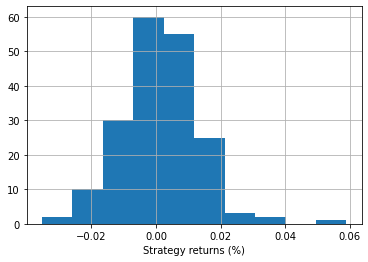

In [136]:
df_rf['strategy_returns'] = df_rf['percent_change'].shift(-1) * model.predict(X)

df_rf.strategy_returns[split:].hist()
plt.xlabel('Strategy returns (%)')
plt.show()

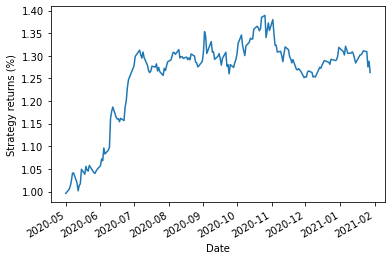

In [137]:
(df_rf.strategy_returns[split:]+1).cumprod().plot()
plt.ylabel('Strategy returns (%)')
plt.show()

# **DECISION-TREE PREDICTION MODEL**



In [138]:
#stock = web.DataReader('^GSPC', 'yahoo', start, end)
# stock.reset_index(inplace=True,drop=False)
# stock['Date']
df_prediction = stock

In [139]:
#Create a variable to predict 'x' days out into the future
future_days = 25

#Create a new column (the target or dependent variable) shifted 'x' units/days up
df_prediction['Prediction'] = df_prediction[['Close']].shift(-future_days)

In [140]:
X = np.array(df_prediction.drop(['Prediction'], 1))[:-future_days]


In [141]:
y = np.array(df_prediction['Prediction'])[:-future_days]

In [142]:
#Splitting the Date (25% Testdata/75% Trainingdata)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [143]:
#Create the decision tree regressor model
tree = DecisionTreeRegressor().fit(x_train, y_train)


In [144]:
#Get the feature data, 
#AKA all the rows from the original data set except the last 'x' days
x_future = df_prediction.drop(['Prediction'], 1)[:-future_days]
#Get the last 'x' rows
x_future = x_future.tail(future_days) 
#Convert the data set into a numpy array
x_future = np.array(x_future)
#Show the model tree prediction
tree_prediction = tree.predict(x_future)


In [145]:
#Prediction Accuracy

tree.score(x_test, y_test)*100
#Ergebniss glaub ich noch nicht


90.08885578018732

In [146]:
#Plot the data
valid =  df_prediction[X.shape[0]:]
valid['Prediction'] = tree_prediction 
  
# S&P500 Stock
figure_prediction = go.Figure(data=[
                               go.Candlestick(
                                   x=df.index,
                                       open=df['Open'],
                                       high=df['High'],
                                       low=df['Low'],
                                       close=df['Close'],
                                       name='S&P 500'),
                               ])

figure_prediction.add_trace(go.Scatter(x=valid.index,
                              y=valid['Prediction'],
                              mode='lines',
                              name='Prediction',
                              line=go.scatter.Line(color='blue')))

figure_update_layout(figure_prediction, 'Prediction - Stock Movement', 'Date', 'Stock Price')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# **Check future days and if the market tends to fall**

In [147]:
#MACD for future days
predict_macd = pd.DataFrame(df, index=df.index)

# Compute EMA by defining short- and long average. 12 days and 26 days
predict_macd['ema_short_avg'] = valid['Close'].ewm(span=12, adjust=False).mean()
predict_macd['ema_long_avg'] = valid['Close'].ewm(span=26, adjust=False).mean()

# Get MACD by dividing EMA (12 days) - EMA (26 days)
predict_macd['macd'] = predict_macd['ema_short_avg'] - predict_macd['ema_long_avg']

predict_macd['signalline'] = predict_macd['macd'].ewm(span=9, adjust=False).mean()

predict_macd.dropna(inplace=True)

In [148]:
print(predict_macd['signalline'].mean(), predict_macd['macd'].mean())

15.73707102252908 20.65345212121116


In [149]:
def predict_falling_market():
  future_dead_cat_bounce = np.where((predict_macd['signalline'].mean() > predict_macd['macd'].mean()) &
                                  (indicator.signalline > indicator.macd) &
                                  ((pct_change_close >= 0.05) | (pct_change_close <= -0.05)) &
                                  (indicator.Open < indicator.lower_band),
                                  True, False)

  indicator['future_dead_cat_bounce'] = future_dead_cat_bounce

  future_dead_cat_bounce = indicator[(indicator['future_dead_cat_bounce'] == True)]

  figure_stock.add_trace(
      go.Scatter(
          mode='markers',
          x=future_dead_cat_bounce.index,
          y=future_dead_cat_bounce['Open'],
          marker_symbol='triangle-down',
          marker=dict(
              color='Green',
              size=20,
              opacity=0.5,
              line=dict(
                  color='Blue',
                  width=2)),
          showlegend=True,
          name='Dead Cat Bounce With Prediction'))

  # push will be triggered if a Dead Cat Bounce happens "today"
  if (dt.datetime.today() in future_dead_cat_bounce.index):
    send_push('Watch out, you might run into a Dead Cat Bounce!')

In [150]:
predict_falling_market()

# **Plot Graphs**

In [151]:
# Plot graph including dead cat bounce but without prediction
plot_dead_cat_bounce()

# Plot graphs in total
figure_stock.show()
figure_macd.show()
figure_prediction.show()